In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, skew, kurtosis
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# --- STEP 1: Generate the Time Series ---
# We are creating a **stationary Gaussian time series**, which by definition satisfies both weak and strict stationarity.
# Parameters:
# - Mean (µ): 0
# - Variance (σ²): 1

np.random.seed(42)  # Seed ensures results are reproducible
n = 1000  # Number of time points
mu = 0    # Mean of the distribution
sigma = 1 # Standard deviation of the distribution
time_series = np.random.normal(mu, sigma, n)








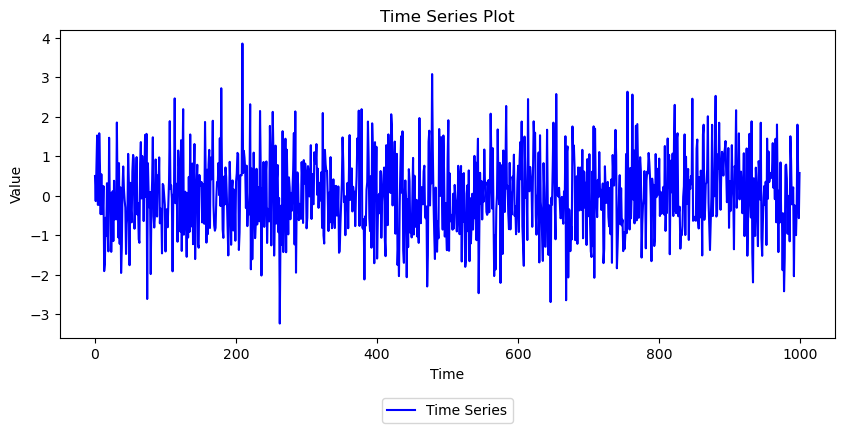

In [46]:
# --- STEP 2: Weak Stationarity ---
# A time series is **weakly stationary** if:
# 1. The mean (E[X_t]) is constant across time.
# 2. The variance (Var(X_t)) is constant across time.
# 3. The autocovariance (Cov(X_t, X_{t+h})) depends only on the lag h, not on time t.

# --- 2.1: Visual Inspection ---
# Plot the time series to observe whether it shows any trend or changing variance.
plt.figure(figsize=(10, 4))
plt.plot(time_series, color="blue", label="Time Series")
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=1)
plt.savefig("time_series_plot.png", transparent=True, bbox_inches="tight")
plt.show()


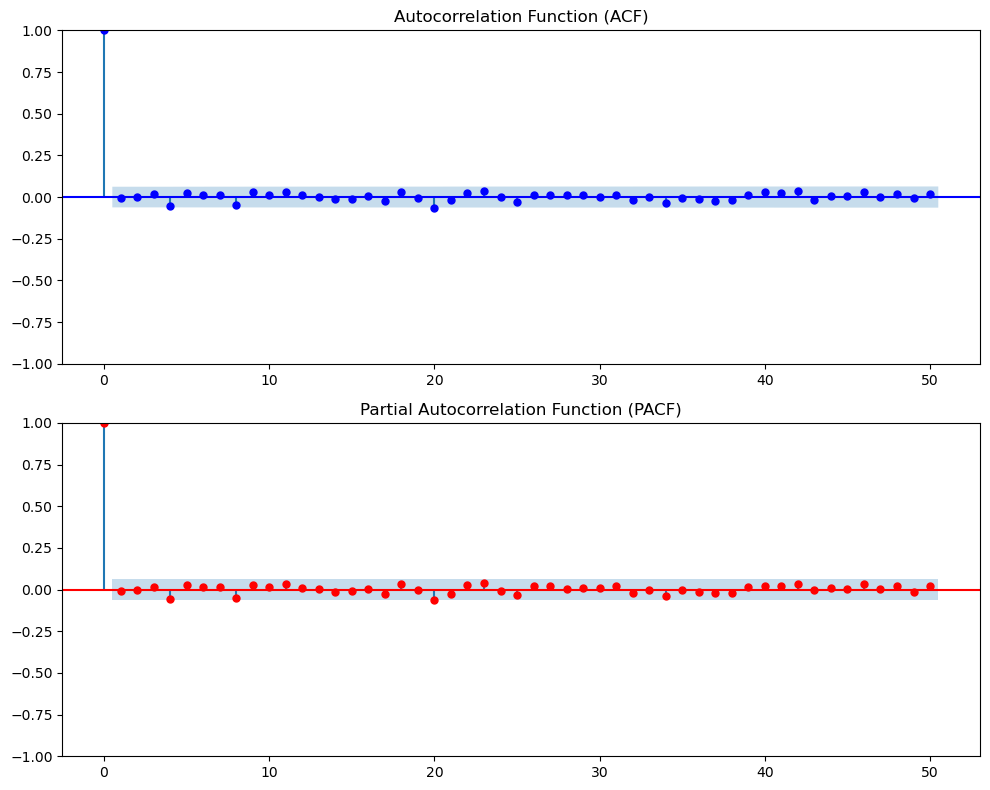

In [33]:
# --- 2.2: ACF and PACF ---
# ACF: Measures the correlation of a time series with its lagged versions.
# PACF: Measures the direct influence of a lag, removing intermediate effects.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(time_series, lags=50, ax=ax[0], color="blue")
ax[0].set_title("Autocorrelation Function (ACF)")
sm.graphics.tsa.plot_pacf(time_series, lags=50, ax=ax[1], method="ywm", color="red")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.savefig("acf_pacf_plot.png", transparent=True, bbox_inches="tight")
plt.show()

In [34]:

# --- 2.3: Augmented Dickey-Fuller (ADF) Test ---
# The ADF test examines whether a unit root is present in the series.
# Formula for ADF statistic:
#   ADF = [(Y_t - α - β * t)^2] / Variance of residuals
# Hypotheses:
# - Null Hypothesis (H₀): The series is non-stationary (contains a unit root).
# - Alternative Hypothesis (H₁): The series is stationary.

adf_test = adfuller(time_series)
print("\nAugmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_test[0]:.3f}")
print(f"p-value: {adf_test[1]:.3f}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"  {key}: {value:.3f}")

if adf_test[1] < 0.05:
    print("The time series is stationary (reject H₀).")
else:
    print("The time series is not stationary (fail to reject H₀).")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -31.811
p-value: 0.000
Critical Values:
  1%: -3.437
  5%: -2.864
  10%: -2.568
The time series is stationary (reject H₀).


In [35]:

# --- STEP 3: Strict Stationarity ---
# Strict stationarity requires the **joint distribution** of (X_t, X_{t+h}) to be invariant over time.
# We test for strict stationarity by:
# 1. Comparing distributions of random splits of the time series using:
#    - Kolmogorov-Smirnov (KS) Test: Compares cumulative distributions.
#    - Higher-order moments (mean, variance, skewness, kurtosis).
# 2. Calculating empirical p-values from multiple random splits.

# Function to split the time series randomly
def random_split(time_series, split_ratio=0.5):
    """
    Splits the time series into two random subsets.
    """
    indices = np.random.permutation(len(time_series))  # Shuffle indices
    split_point = int(len(time_series) * split_ratio)  # Split point
    subset1 = time_series[indices[:split_point]]  # First subset
    subset2 = time_series[indices[split_point:]]  # Second subset
    return subset1, subset2

# Perform 1000 random splits to calculate empirical distributions of test statistics
num_iterations = 1000  # Number of random splits
ks_stats = []          # Kolmogorov-Smirnov statistics
mean_diffs = []        # Differences in means
variance_diffs = []    # Differences in variances
skewness_diffs = []    # Differences in skewness
kurtosis_diffs = []    # Differences in kurtosis

for _ in range(num_iterations):
    subset1, subset2 = random_split(time_series)
    
    # Kolmogorov-Smirnov Test: Compare cumulative distributions
    ks_stat, _ = ks_2samp(subset1, subset2)
    ks_stats.append(ks_stat)
    
    # Calculate differences in moments
    mean_diffs.append(np.abs(np.mean(subset1) - np.mean(subset2)))
    variance_diffs.append(np.abs(np.var(subset1) - np.var(subset2)))
    skewness_diffs.append(np.abs(skew(subset1) - skew(subset2)))
    kurtosis_diffs.append(np.abs(kurtosis(subset1) - kurtosis(subset2)))

# Observed values for a single random split
subset1, subset2 = random_split(time_series)
obs_ks_stat, _ = ks_2samp(subset1, subset2)
obs_mean_diff = np.abs(np.mean(subset1) - np.mean(subset2))
obs_variance_diff = np.abs(np.var(subset1) - np.var(subset2))
obs_skewness_diff = np.abs(skew(subset1) - skew(subset2))
obs_kurtosis_diff = np.abs(kurtosis(subset1) - kurtosis(subset2))

# Empirical p-values
empirical_p_ks = np.mean([stat >= obs_ks_stat for stat in ks_stats])
empirical_p_mean = np.mean([diff >= obs_mean_diff for diff in mean_diffs])
empirical_p_variance = np.mean([diff >= obs_variance_diff for diff in variance_diffs])
empirical_p_skewness = np.mean([diff >= obs_skewness_diff for diff in skewness_diffs])
empirical_p_kurtosis = np.mean([diff >= obs_kurtosis_diff for diff in kurtosis_diffs])

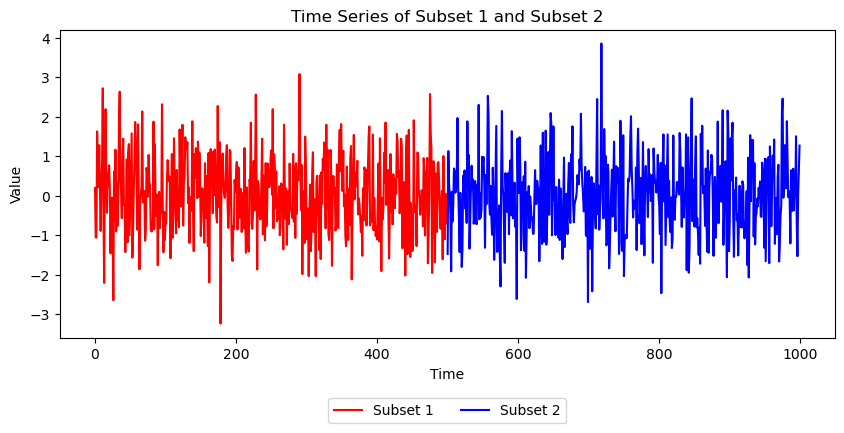

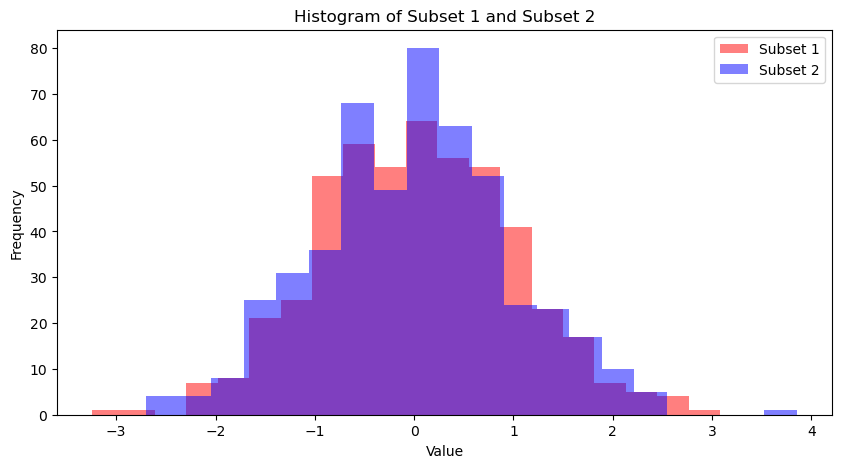

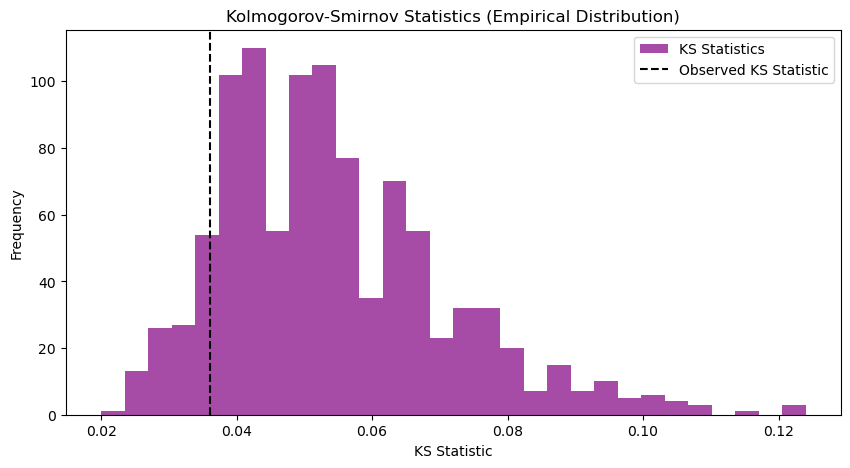

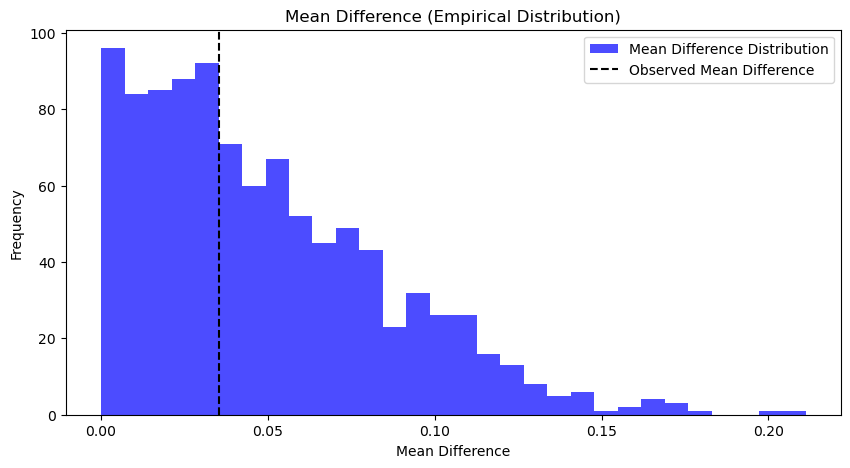

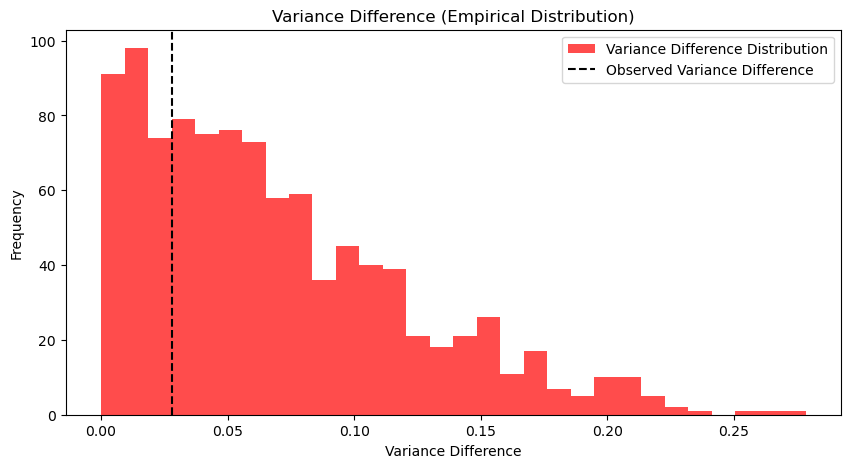

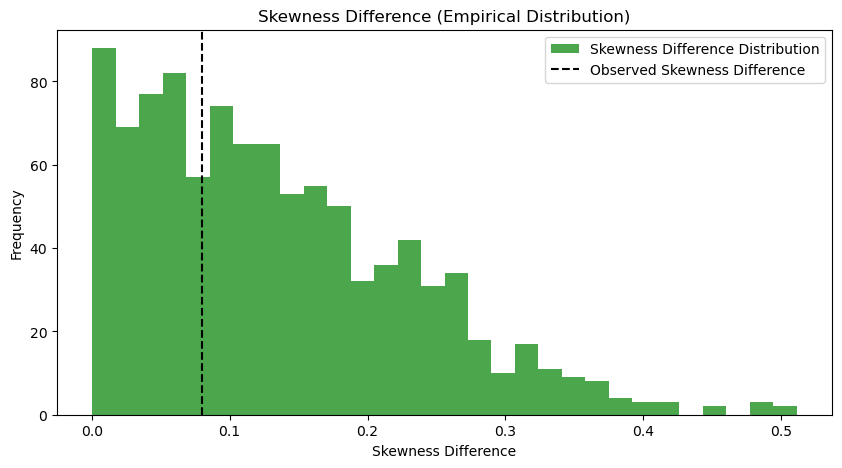

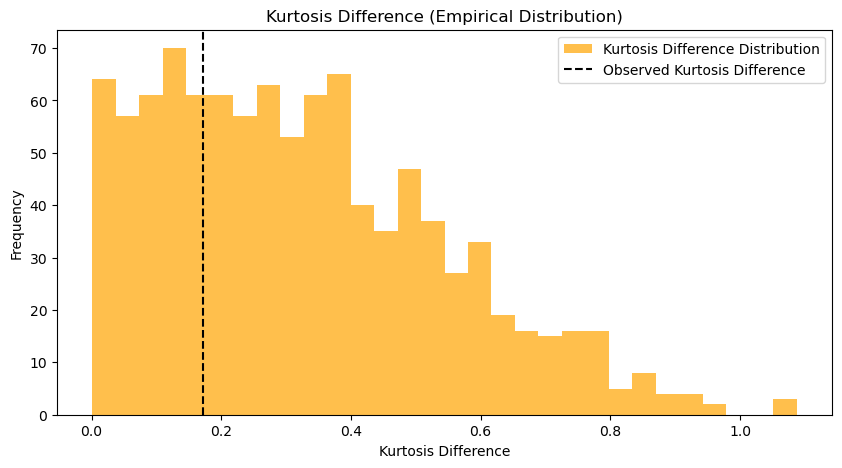


Strict Stationarity Test Results:
Observed KS Statistic: 0.036, Empirical p-value: 0.908
Observed Mean Difference: 0.035, Empirical p-value: 0.555
Observed Variance Difference: 0.028, Empirical p-value: 0.736
Observed Skewness Difference: 0.080, Empirical p-value: 0.646
Observed Kurtosis Difference: 0.172, Empirical p-value: 0.711
The time series is strictly stationary (no evidence against strict stationarity).


In [50]:

# --- STEP 4: Visualization ---

# Time Series Plots for Subset 1 and Subset 2
plt.figure(figsize=(10, 4))
plt.plot(subset1, color="red", label="Subset 1")
plt.plot(range(len(subset1), len(subset1) + len(subset2)), subset2, color="blue", label="Subset 2")
plt.title("Time Series of Subset 1 and Subset 2")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plt.savefig("subset_time_series.png", transparent=True, bbox_inches="tight")
plt.show()

# Histogram for Subset 1 and Subset 2
plt.figure(figsize=(10, 5))
plt.hist(subset1, bins=20, alpha=0.5, color="red", label="Subset 1")
plt.hist(subset2, bins=20, alpha=0.5, color="blue", label="Subset 2")
plt.title("Histogram of Subset 1 and Subset 2")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.savefig("subset_histograms.png", transparent=True, bbox_inches="tight")
plt.show()

# Kolmogorov-Smirnov Statistic Distribution
plt.figure(figsize=(10, 5))
plt.hist(ks_stats, bins=30, alpha=0.7, color="purple", label="KS Statistics")
plt.axvline(obs_ks_stat, color="black", linestyle="--", label="Observed KS Statistic")
plt.title("Kolmogorov-Smirnov Statistics (Empirical Distribution)")
plt.xlabel("KS Statistic")
plt.ylabel("Frequency")
plt.legend(loc="upper right")
plt.savefig("ks_stat_distribution.png", transparent=True, bbox_inches="tight")
plt.show()

# Moment Difference Distributions
moment_labels = ["Mean Difference", "Variance Difference", "Skewness Difference", "Kurtosis Difference"]
moment_values = [mean_diffs, variance_diffs, skewness_diffs, kurtosis_diffs]
observed_values = [obs_mean_diff, obs_variance_diff, obs_skewness_diff, obs_kurtosis_diff]
colors = ["blue", "red", "green", "orange"]

for label, values, obs_value, color in zip(moment_labels, moment_values, observed_values, colors):
    plt.figure(figsize=(10, 5))
    plt.hist(values, bins=30, alpha=0.7, color=color, label=f"{label} Distribution")
    plt.axvline(obs_value, color="black", linestyle="--", label=f"Observed {label}")
    plt.title(f"{label} (Empirical Distribution)")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    plt.savefig(f"{label.lower().replace(' ', '_')}_distribution.png", transparent=True, bbox_inches="tight")
    plt.show()

# --- STEP 5: Results ---
print("\nStrict Stationarity Test Results:")
print(f"Observed KS Statistic: {obs_ks_stat:.3f}, Empirical p-value: {empirical_p_ks:.3f}")
print(f"Observed Mean Difference: {obs_mean_diff:.3f}, Empirical p-value: {empirical_p_mean:.3f}")
print(f"Observed Variance Difference: {obs_variance_diff:.3f}, Empirical p-value: {empirical_p_variance:.3f}")
print(f"Observed Skewness Difference: {obs_skewness_diff:.3f}, Empirical p-value: {empirical_p_skewness:.3f}")
print(f"Observed Kurtosis Difference: {obs_kurtosis_diff:.3f}, Empirical p-value: {empirical_p_kurtosis:.3f}")

if all(p > 0.05 for p in [empirical_p_ks, empirical_p_mean, empirical_p_variance, empirical_p_skewness, empirical_p_kurtosis]):
    print("The time series is strictly stationary (no evidence against strict stationarity).")
else:
    print("The time series fails strict stationarity tests (evidence against strict stationarity).")